# Dog Breed Classification Model 🐶

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

A file with prediction probabilities of each dog breed for each test image.

## 4. Features

Info about the data:
* Using unstructured data (images) so will be best to use deep learning/transfer learning.
* There are 120 breeds meaning, 120 different classes.
* There are 10,000+ images in the training set (with labels)
* There are 10,000+ images in the test set (no labels) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import tensorflow_hub as hub


In [2]:
# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")


GPU available


## Getting our data ready (turning it into Tensors)

In [3]:
# Checkout the labels of our data

labels_csv = pd.read_csv("data/labels.csv")
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


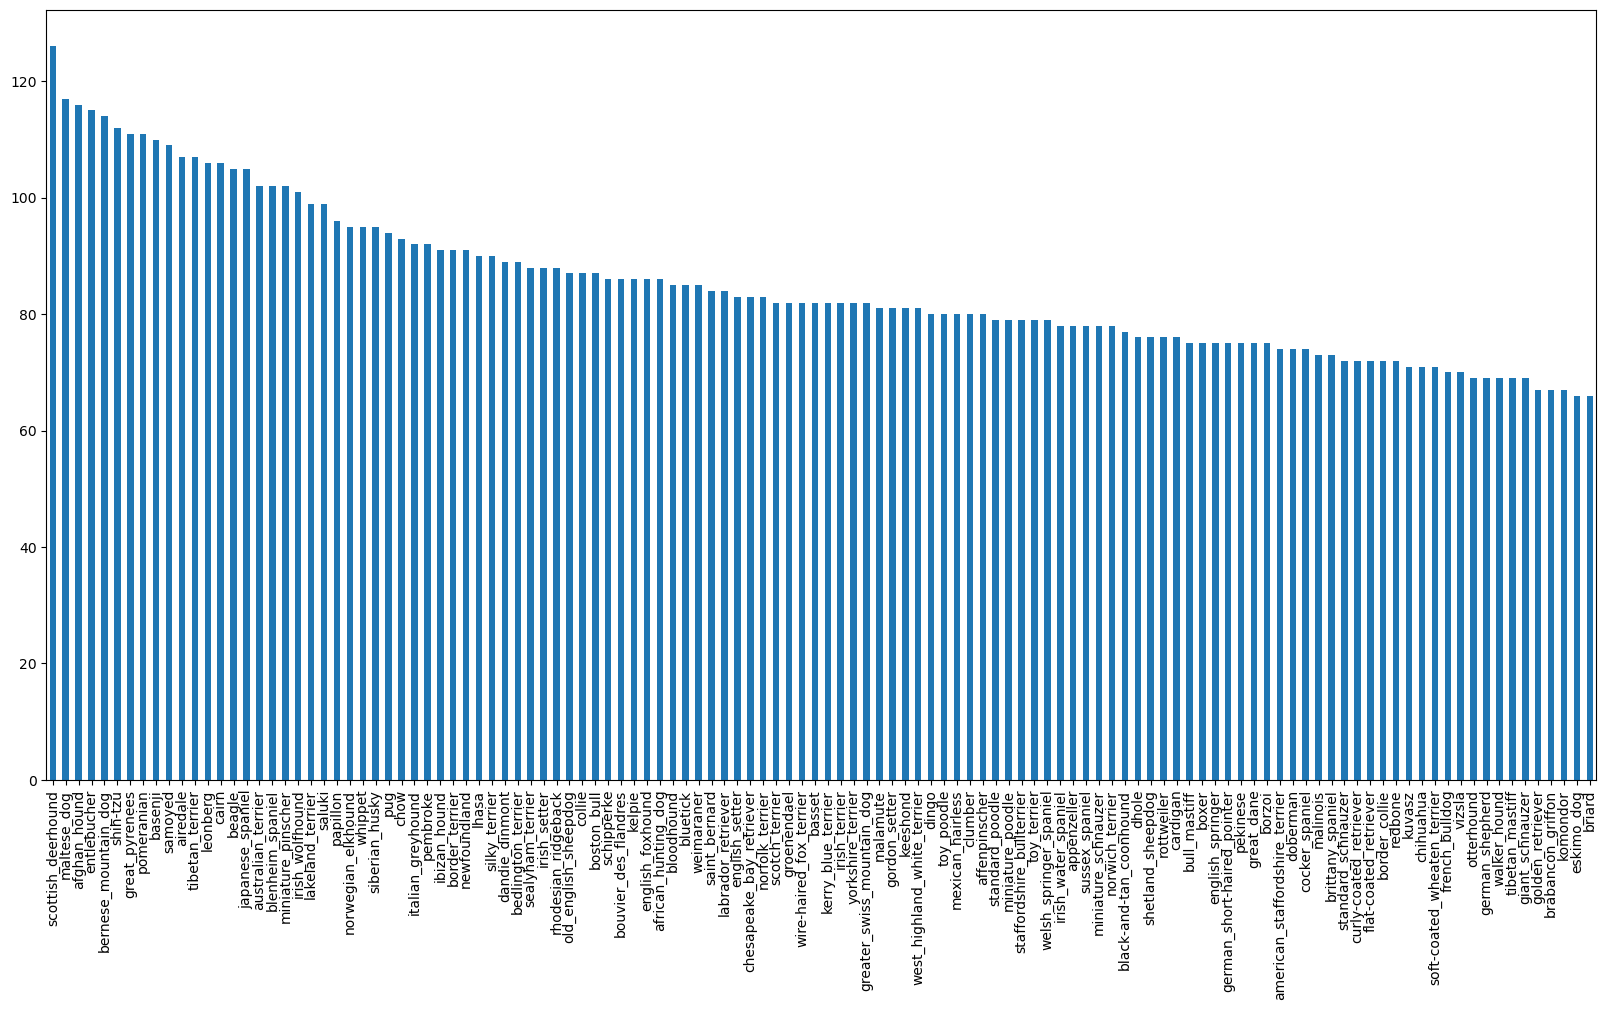

In [6]:
# How many images are there of each breed?

labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [8]:
labels_csv["breed"].value_counts().median()

82.0

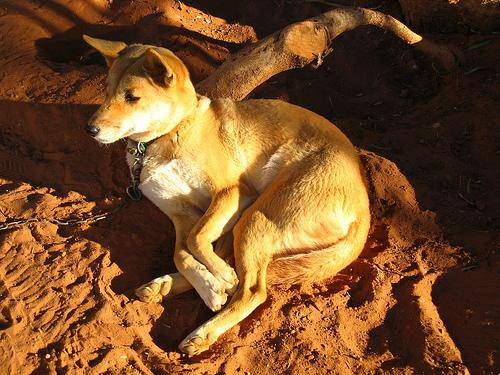

In [9]:
# View an image

from IPython.display import Image
Image("data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")